# Hubert + MLP Parkinson Detection Model

## imports

In [1]:
from plot_tensorboard import plot_training
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sys
from plot_conf_mat import plot_cm
import numpy as np


2025-04-24 21:27:55.499467: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-24 21:27:55.524038: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-24 21:27:55.531512: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-24 21:27:55.552468: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-24 21:27:57.974241: W tensorflow/comp

## Experiment on Full Dataset

### hparams file

In [4]:
%%file hparams_hubert.yaml

# Your code here

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# Dataset will be downloaded to the `data_original`
data_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons
output_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons-results/hubert/base/fulldataset/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# URL for the ssl model, you can change to benchmark diffrenet models
# Important: we use wav2vec2 base and not the fine-tuned one with ASR task
# This allow you to have ~4% improvment
sslmodel_hub: facebook/hubert-base-ls960
sslmodel_folder: !ref <save_folder>/ssl_checkpoint

# Path where data manifest files will be stored
train_annotation: /home/ulaval.ca/maelr5/parkinsons/train.json
valid_annotation: /home/ulaval.ca/maelr5/parkinsons/valid.json
test_annotation: /home/ulaval.ca/maelr5/parkinsons/test.json

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

# Tensorboard logs
use_tensorboard: False
tensorboard_logs_folder: !ref <output_folder>/tb_logs/

####################### Training Parameters ####################################
number_of_epochs: 10
batch_size: 4
lr: 0.0001
lr_ssl: 0.00001
sample_rate: 16000

#freeze all ssl
freeze_ssl: False
#set to true to freeze the CONV part of the ssl model
# We see an improvement of 2% with freezing CNNs
freeze_ssl_conv: True

####################### Model Parameters #######################################
encoder_dim: 768

# Number of emotions
out_n_neurons: 2 # (healthy, parkinsons)

dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: True
    num_workers: 2  # 2 on linux but 0 works on windows
    drop_last: False

# ssl encoder; HuBERT and Wav2Vec2 both use the same SpeechBrain wrapper
ssl_model: !new:speechbrain.lobes.models.huggingface_transformers.wav2vec2.Wav2Vec2
    source: !ref <sslmodel_hub>
    output_norm: True
    freeze: !ref <freeze_ssl>
    freeze_feature_extractor: !ref <freeze_ssl_conv>
    save_path: !ref <sslmodel_folder>

avg_pool: !new:speechbrain.nnet.pooling.StatisticsPooling
    return_std: False

output_mlp: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <encoder_dim>
    n_neurons: !ref <out_n_neurons>
    bias: False

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

modules:
    ssl_model: !ref <ssl_model>
    output_mlp: !ref <output_mlp>

model: !new:torch.nn.ModuleList
    - [!ref <output_mlp>]

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

compute_cost: !name:speechbrain.nnet.losses.nll_loss

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

opt_class: !name:torch.optim.Adam
    lr: !ref <lr>

ssl_opt_class: !name:torch.optim.Adam
    lr: !ref <lr_ssl>

lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.9
    patient: 0

lr_annealing_ssl: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr_ssl>
    improvement_threshold: 0.0025
    annealing_factor: 0.9

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        ssl_model: !ref <ssl_model>
        lr_annealing_output: !ref <lr_annealing>
        lr_annealing_ssl: !ref <lr_annealing_ssl>
        counter: !ref <epoch_counter>


Overwriting hparams_hubert.yaml


### Training file
use same trainwav2vec.py script for training

In [5]:
!rm -rf /home/ulaval.ca/maelr5/scratch/parkinsons-results/hubert/base/fulldataset/1986

import sys

!{sys.executable} trainwav2vec.py hparams_hubert.yaml --data_folder='/home/ulaval.ca/maelr5/scratch/parkinsons' --device='cuda:0' --number_of_epochs=10 --use_tensorboard=True


2025-04-22 02:04:24.350642: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-22 02:04:24.372329: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-22 02:04:24.379246: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-22 02:04:24.397972: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-22 02:04:27.613141: W tensorflow/comp

### output (Train log)

```
Epoch: 1, lr: 1.00e-04, ssl_lr: 1.00e-05 - train loss: 4.50e-01 - valid loss: 1.21e-01, valid acc: 9.90e-01, valid error_rate: 1.04e-02
Epoch: 2, lr: 1.00e-04, ssl_lr: 1.00e-05 - train loss: 1.52e-01 - valid loss: 7.58e-02, valid acc: 9.90e-01, valid error_rate: 1.04e-02
Epoch: 3, lr: 9.00e-05, ssl_lr: 9.00e-06 - train loss: 5.84e-02 - valid loss: 1.04e-01, valid acc: 9.90e-01, valid error_rate: 1.04e-02
Epoch: 4, lr: 8.10e-05, ssl_lr: 8.10e-06 - train loss: 7.57e-02 - valid loss: 1.20e-01, valid acc: 9.90e-01, valid error_rate: 1.04e-02
Epoch: 5, lr: 7.29e-05, ssl_lr: 7.29e-06 - train loss: 8.24e-02 - valid loss: 1.08e-01, valid acc: 9.90e-01, valid error_rate: 1.04e-02
Epoch: 6, lr: 6.56e-05, ssl_lr: 6.56e-06 - train loss: 3.07e-02 - valid loss: 1.13e-01, valid acc: 9.90e-01, valid error_rate: 1.04e-02
Epoch: 7, lr: 5.90e-05, ssl_lr: 5.90e-06 - train loss: 2.23e-02 - valid loss: 1.14e-01, valid acc: 9.90e-01, valid error_rate: 1.04e-02
Epoch: 8, lr: 5.31e-05, ssl_lr: 5.31e-06 - train loss: 2.90e-02 - valid loss: 1.17e-01, valid acc: 9.90e-01, valid error_rate: 1.04e-02
Epoch: 9, lr: 4.78e-05, ssl_lr: 4.78e-06 - train loss: 1.72e-02 - valid loss: 1.18e-01, valid acc: 9.90e-01, valid error_rate: 1.04e-02
Epoch: 10, lr: 4.30e-05, ssl_lr: 4.30e-06 - train loss: 2.41e-02 - valid loss: 1.22e-01, valid acc: 9.90e-01, valid error_rate: 1.04e-02
Epoch loaded: 10, 
 Per Class Accuracy: 
0: 1.000
1: 1.000, 
 Confusion Matrix: 
[[48  0]
 [ 0 38]]
 - test loss: 2.90e-05, test acc: 1.00e+00, test error_rate: 0.00e+00
```

'PD' => 0

'HC' => 1


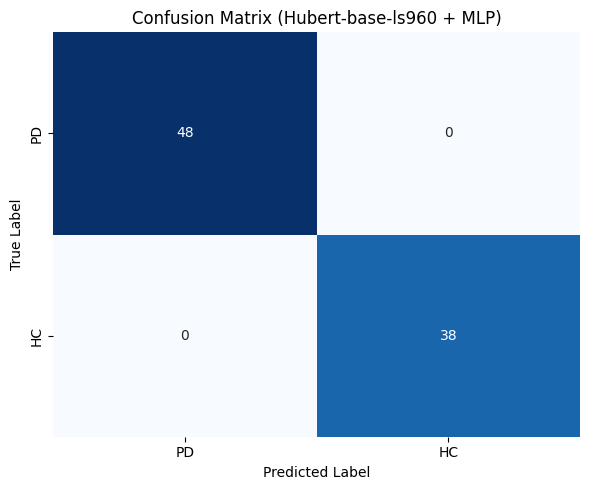

In [2]:

conf_matrix = np.array([[48, 0],   # True PD
                        [0, 38]])  # True HC

plot_cm(conf_matrix, title='Confusion Matrix (Hubert-base-ls960 + MLP)')


### plot the train/valid loss/accuracy during training

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


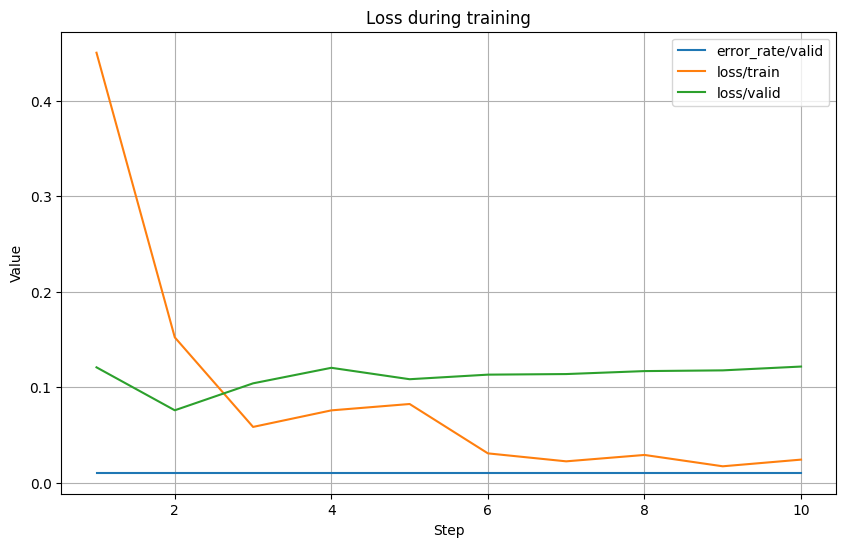

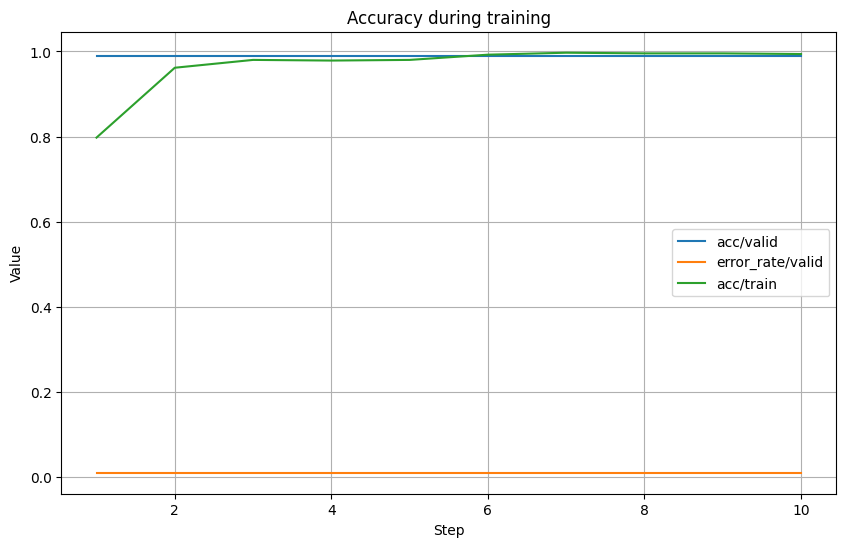

In [3]:
event_file = "/home/ulaval.ca/maelr5/scratch/parkinsons-results/hubert/base/fulldataset/1986/tb_logs/events.out.tfevents.1745303119.ul-val-pr-cpc02.l.ul.ca.2257704.0"
plot_training(event_file)


### Results Analysis:

We also evaluated the hubert-base model with the same architecture and training pipeline. Remarkably, the HuBERT-based system achieved 100% accuracy on the test set, perfectly classifying both Parkinson’s disease and healthy control samples. This suggests that HuBERT’s learned speech representations are highly effective for distinguishing subtle vocal markers associated with Parkinson’s. This result demonstrates the potential of leveraging self-supervised models beyond ASR, particularly in clinical speech analysis.

## Vowels Data

### hparams file

In [2]:
%%file hparams_hubert_vowels.yaml

# Your code here

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# Dataset will be downloaded to the `data_original`
data_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons
output_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons-results/hubert/base/vowels/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# URL for the ssl model, you can change to benchmark diffrenet models
# Important: we use wav2vec2 base and not the fine-tuned one with ASR task
# This allow you to have ~4% improvment
sslmodel_hub: facebook/hubert-base-ls960
sslmodel_folder: !ref <save_folder>/ssl_checkpoint

# Path where data manifest files will be stored
train_annotation: /home/ulaval.ca/maelr5/parkinsons/train_vowels.json
valid_annotation: /home/ulaval.ca/maelr5/parkinsons/valid_vowels.json
test_annotation: /home/ulaval.ca/maelr5/parkinsons/test_vowels.json

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

# Tensorboard logs
use_tensorboard: False
tensorboard_logs_folder: !ref <output_folder>/tb_logs/

####################### Training Parameters ####################################
number_of_epochs: 10
batch_size: 4
lr: 0.0001
lr_ssl: 0.00001
sample_rate: 16000

#freeze all ssl
freeze_ssl: False
#set to true to freeze the CONV part of the ssl model
# We see an improvement of 2% with freezing CNNs
freeze_ssl_conv: True

####################### Model Parameters #######################################
encoder_dim: 768

# Number of emotions
out_n_neurons: 2 # (healthy, parkinsons)

dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: True
    num_workers: 2  # 2 on linux but 0 works on windows
    drop_last: False

# ssl encoder; HuBERT and Wav2Vec2 both use the same SpeechBrain wrapper
ssl_model: !new:speechbrain.lobes.models.huggingface_transformers.wav2vec2.Wav2Vec2
    source: !ref <sslmodel_hub>
    output_norm: True
    freeze: !ref <freeze_ssl>
    freeze_feature_extractor: !ref <freeze_ssl_conv>
    save_path: !ref <sslmodel_folder>

avg_pool: !new:speechbrain.nnet.pooling.StatisticsPooling
    return_std: False

output_mlp: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <encoder_dim>
    n_neurons: !ref <out_n_neurons>
    bias: False

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

modules:
    ssl_model: !ref <ssl_model>
    output_mlp: !ref <output_mlp>

model: !new:torch.nn.ModuleList
    - [!ref <output_mlp>]

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

compute_cost: !name:speechbrain.nnet.losses.nll_loss

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

opt_class: !name:torch.optim.Adam
    lr: !ref <lr>

ssl_opt_class: !name:torch.optim.Adam
    lr: !ref <lr_ssl>

lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.9
    patient: 0

lr_annealing_ssl: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr_ssl>
    improvement_threshold: 0.0025
    annealing_factor: 0.9

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        ssl_model: !ref <ssl_model>
        lr_annealing_output: !ref <lr_annealing>
        lr_annealing_ssl: !ref <lr_annealing_ssl>
        counter: !ref <epoch_counter>


Writing hparams_hubert_vowels.yaml


In [4]:
!rm -rf /home/ulaval.ca/maelr5/scratch/parkinsons-results/hubert/base/vowels/1986

import sys

!{sys.executable} trainwav2vec.py hparams_hubert_vowels.yaml --data_folder='/home/ulaval.ca/maelr5/scratch/parkinsons' --device='cuda:0' --number_of_epochs=10 --use_tensorboard=True


2025-04-24 21:48:36.130461: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-24 21:48:36.153568: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-24 21:48:36.160675: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-24 21:48:36.179739: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-24 21:48:39.185963: W tensorflow/comp

### output train log:
```
Epoch: 1, lr: 1.00e-04, ssl_lr: 1.00e-05 - train loss: 3.92e-01 - valid loss: 7.00e-02, valid acc: 9.83e-01, valid error_rate: 1.67e-02
Epoch: 2, lr: 1.00e-04, ssl_lr: 1.00e-05 - train loss: 1.25e-01 - valid loss: 1.18e-02, valid acc: 1.00e+00, valid error_rate: 0.00e+00
Epoch: 3, lr: 1.00e-04, ssl_lr: 1.00e-05 - train loss: 7.86e-02 - valid loss: 1.66e-03, valid acc: 1.00e+00, valid error_rate: 0.00e+00
Epoch: 4, lr: 9.00e-05, ssl_lr: 9.00e-06 - train loss: 5.97e-02 - valid loss: 3.33e-04, valid acc: 1.00e+00, valid error_rate: 0.00e+00
Epoch: 5, lr: 8.10e-05, ssl_lr: 8.10e-06 - train loss: 2.77e-02 - valid loss: 5.23e-02, valid acc: 9.83e-01, valid error_rate: 1.67e-02
Epoch: 6, lr: 7.29e-05, ssl_lr: 7.29e-06 - train loss: 2.17e-02 - valid loss: 1.09e-04, valid acc: 1.00e+00, valid error_rate: 0.00e+00
Epoch: 7, lr: 7.29e-05, ssl_lr: 7.29e-06 - train loss: 5.00e-02 - valid loss: 8.02e-04, valid acc: 1.00e+00, valid error_rate: 0.00e+00
Epoch: 8, lr: 6.56e-05, ssl_lr: 6.56e-06 - train loss: 1.53e-02 - valid loss: 1.45e-04, valid acc: 1.00e+00, valid error_rate: 0.00e+00
Epoch: 9, lr: 5.90e-05, ssl_lr: 5.90e-06 - train loss: 2.78e-02 - valid loss: 7.45e-05, valid acc: 1.00e+00, valid error_rate: 0.00e+00
Epoch: 10, lr: 5.31e-05, ssl_lr: 5.31e-06 - train loss: 1.28e-03 - valid loss: 4.39e-05, valid acc: 1.00e+00, valid error_rate: 0.00e+00
Epoch loaded: 10, 
 Per Class Accuracy: 
0: 1.000
1: 0.967, 
 Confusion Matrix: 
[[20  0]
 [ 1 29]]
 - test loss: 1.86e-01, test acc: 9.81e-01, test error_rate: 2.00e-02
```

'HC' => 0

'PD' => 1


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


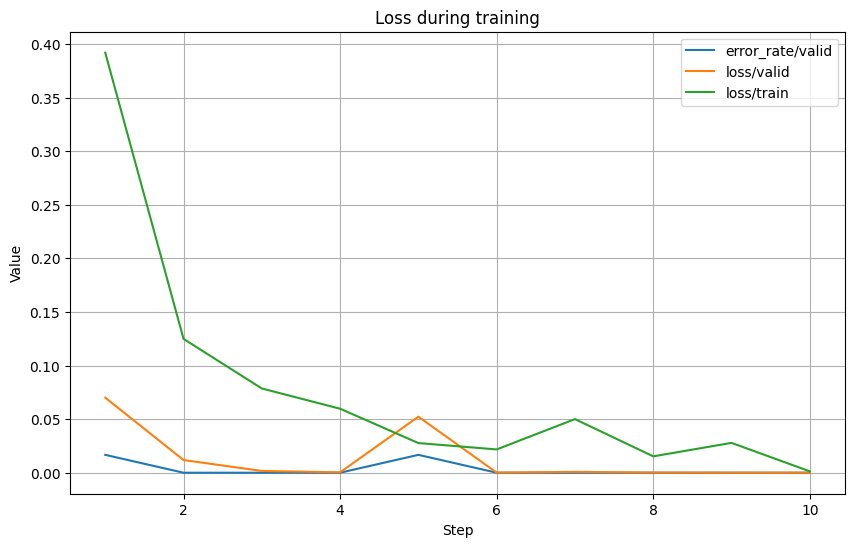

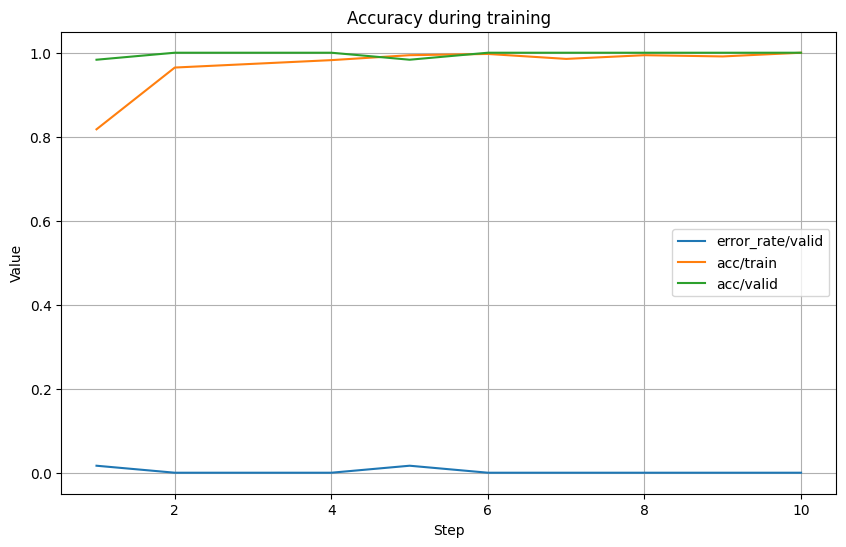

In [7]:
event_file = "/home/ulaval.ca/maelr5/scratch/parkinsons-results/hubert/base/vowels/1986/tb_logs/events.out.tfevents.1745545739.ul-val-pr-gpu05.l.ul.ca.2478786.0"
plot_training(event_file)



## Vowel-a Data

### hparams file

In [9]:
%%file hparams_hubert_vowela.yaml

# Your code here

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# Dataset will be downloaded to the `data_original`
data_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons
output_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons-results/hubert/base/vowela/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# URL for the ssl model, you can change to benchmark diffrenet models
# Important: we use wav2vec2 base and not the fine-tuned one with ASR task
# This allow you to have ~4% improvment
sslmodel_hub: facebook/hubert-base-ls960
sslmodel_folder: !ref <save_folder>/ssl_checkpoint

# Path where data manifest files will be stored
train_annotation: /home/ulaval.ca/maelr5/parkinsons/train_vowela.json
valid_annotation: /home/ulaval.ca/maelr5/parkinsons/valid_vowela.json
test_annotation: /home/ulaval.ca/maelr5/parkinsons/test_vowela.json

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

# Tensorboard logs
use_tensorboard: False
tensorboard_logs_folder: !ref <output_folder>/tb_logs/

####################### Training Parameters ####################################
number_of_epochs: 10
batch_size: 4
lr: 0.0001
lr_ssl: 0.00001
sample_rate: 16000

#freeze all ssl
freeze_ssl: False
#set to true to freeze the CONV part of the ssl model
# We see an improvement of 2% with freezing CNNs
freeze_ssl_conv: True

####################### Model Parameters #######################################
encoder_dim: 768

# Number of emotions
out_n_neurons: 2 # (healthy, parkinsons)

dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: True
    num_workers: 2  # 2 on linux but 0 works on windows
    drop_last: False

# ssl encoder; HuBERT and Wav2Vec2 both use the same SpeechBrain wrapper
ssl_model: !new:speechbrain.lobes.models.huggingface_transformers.wav2vec2.Wav2Vec2
    source: !ref <sslmodel_hub>
    output_norm: True
    freeze: !ref <freeze_ssl>
    freeze_feature_extractor: !ref <freeze_ssl_conv>
    save_path: !ref <sslmodel_folder>

avg_pool: !new:speechbrain.nnet.pooling.StatisticsPooling
    return_std: False

output_mlp: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <encoder_dim>
    n_neurons: !ref <out_n_neurons>
    bias: False

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

modules:
    ssl_model: !ref <ssl_model>
    output_mlp: !ref <output_mlp>

model: !new:torch.nn.ModuleList
    - [!ref <output_mlp>]

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

compute_cost: !name:speechbrain.nnet.losses.nll_loss

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

opt_class: !name:torch.optim.Adam
    lr: !ref <lr>

ssl_opt_class: !name:torch.optim.Adam
    lr: !ref <lr_ssl>

lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.9
    patient: 0

lr_annealing_ssl: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr_ssl>
    improvement_threshold: 0.0025
    annealing_factor: 0.9

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        ssl_model: !ref <ssl_model>
        lr_annealing_output: !ref <lr_annealing>
        lr_annealing_ssl: !ref <lr_annealing_ssl>
        counter: !ref <epoch_counter>


Writing hparams_hubert_vowela.yaml


In [10]:
!rm -rf /home/ulaval.ca/maelr5/scratch/parkinsons-results/hubert/base/vowela/1986

import sys

!{sys.executable} trainwav2vec.py hparams_hubert_vowela.yaml --data_folder='/home/ulaval.ca/maelr5/scratch/parkinsons' --device='cuda:0' --number_of_epochs=10 --use_tensorboard=True


2025-04-24 23:19:48.989198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-24 23:19:49.015896: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-24 23:19:49.023517: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-24 23:19:49.043931: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-24 23:19:52.045485: W tensorflow/comp

### output train log
```
Epoch: 1, lr: 1.00e-04, ssl_lr: 1.00e-05 - train loss: 5.62e-01 - valid loss: 3.51e-01, valid acc: 1.00e+00, valid error_rate: 0.00e+00
Epoch: 2, lr: 1.00e-04, ssl_lr: 1.00e-05 - train loss: 3.06e-01 - valid loss: 9.55e-02, valid acc: 1.00e+00, valid error_rate: 0.00e+00
Epoch: 3, lr: 9.00e-05, ssl_lr: 9.00e-06 - train loss: 2.08e-01 - valid loss: 2.72e-01, valid acc: 8.33e-01, valid error_rate: 1.67e-01
Epoch: 4, lr: 8.10e-05, ssl_lr: 8.10e-06 - train loss: 1.76e-01 - valid loss: 2.07e-02, valid acc: 1.00e+00, valid error_rate: 0.00e+00
Epoch: 5, lr: 8.10e-05, ssl_lr: 8.10e-06 - train loss: 1.33e-01 - valid loss: 2.69e-01, valid acc: 8.33e-01, valid error_rate: 1.67e-01
Epoch: 6, lr: 7.29e-05, ssl_lr: 7.29e-06 - train loss: 1.60e-01 - valid loss: 5.09e-03, valid acc: 1.00e+00, valid error_rate: 0.00e+00
Epoch: 7, lr: 7.29e-05, ssl_lr: 7.29e-06 - train loss: 5.53e-02 - valid loss: 4.92e-03, valid acc: 1.00e+00, valid error_rate: 0.00e+00
Epoch: 8, lr: 6.56e-05, ssl_lr: 6.56e-06 - train loss: 7.20e-02 - valid loss: 1.52e-01, valid acc: 9.17e-01, valid error_rate: 8.33e-02
Epoch: 9, lr: 5.90e-05, ssl_lr: 5.90e-06 - train loss: 2.75e-02 - valid loss: 4.69e-01, valid acc: 8.33e-01, valid error_rate: 1.67e-01
Epoch: 10, lr: 5.31e-05, ssl_lr: 5.31e-06 - train loss: 7.37e-02 - valid loss: 1.64e-01, valid acc: 9.17e-01, valid error_rate: 8.33e-02
Epoch loaded: 7, 
 Per Class Accuracy: 
0: 0.833
1: 1.000, 
 Confusion Matrix: 
[[5 1]
 [0 4]]
 - test loss: 2.88e-01, test acc: 9.17e-01, test error_rate: 1.00e-01
```

'PD' => 0

'HC' => 1


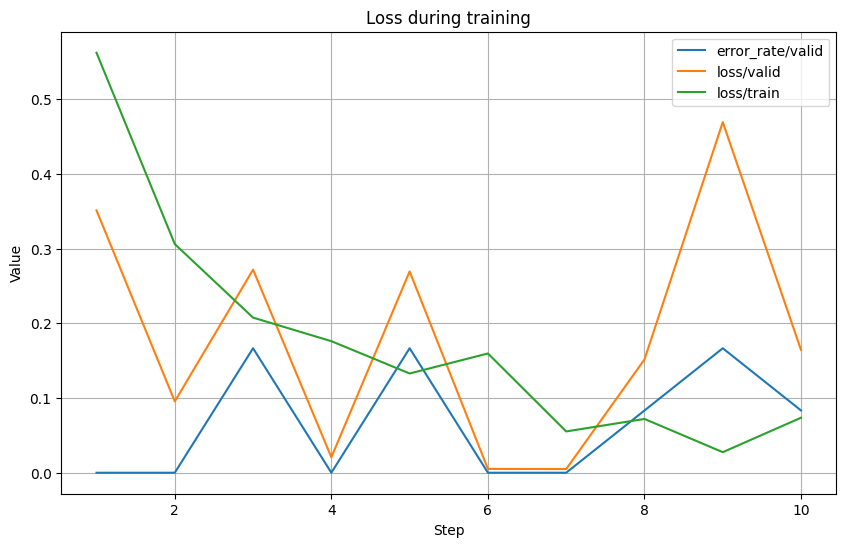

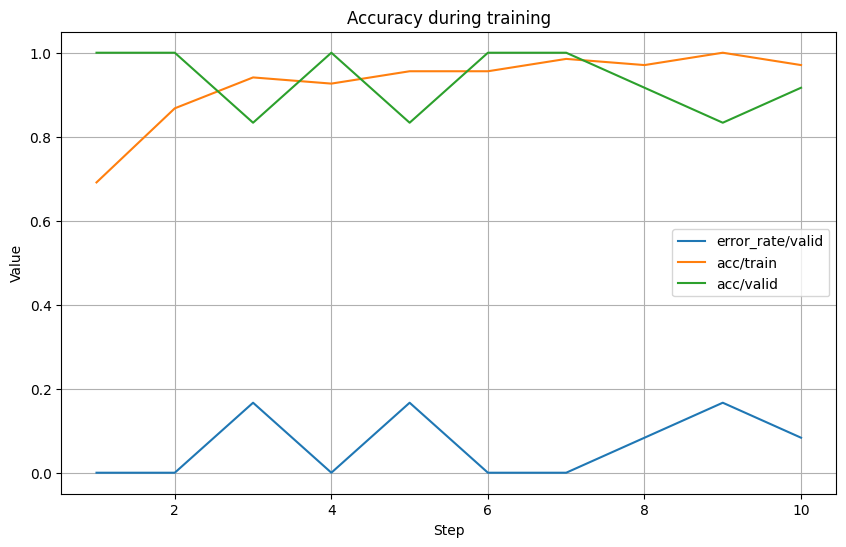

In [11]:
event_file = "/home/ulaval.ca/maelr5/scratch/parkinsons-results/hubert/base/vowela/1986/tb_logs/events.out.tfevents.1745551200.ul-val-pr-gpu05.l.ul.ca.2493332.0"
plot_training(event_file)



## Phrases Data

### hparams file

In [5]:
%%file hparams_hubert_phrases.yaml

# Your code here

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# Dataset will be downloaded to the `data_original`
data_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons
output_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons-results/hubert/base/phrases/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# URL for the ssl model, you can change to benchmark diffrenet models
# Important: we use wav2vec2 base and not the fine-tuned one with ASR task
# This allow you to have ~4% improvment
sslmodel_hub: facebook/hubert-base-ls960
sslmodel_folder: !ref <save_folder>/ssl_checkpoint

# Path where data manifest files will be stored
train_annotation: /home/ulaval.ca/maelr5/parkinsons/train_phrases.json
valid_annotation: /home/ulaval.ca/maelr5/parkinsons/valid_phrases.json
test_annotation: /home/ulaval.ca/maelr5/parkinsons/test_phrases.json

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

# Tensorboard logs
use_tensorboard: False
tensorboard_logs_folder: !ref <output_folder>/tb_logs/

####################### Training Parameters ####################################
number_of_epochs: 10
batch_size: 4
lr: 0.0001
lr_ssl: 0.00001
sample_rate: 16000

#freeze all ssl
freeze_ssl: False
#set to true to freeze the CONV part of the ssl model
# We see an improvement of 2% with freezing CNNs
freeze_ssl_conv: True

####################### Model Parameters #######################################
encoder_dim: 768

# Number of emotions
out_n_neurons: 2 # (healthy, parkinsons)

dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: True
    num_workers: 2  # 2 on linux but 0 works on windows
    drop_last: False

# ssl encoder; HuBERT and Wav2Vec2 both use the same SpeechBrain wrapper
ssl_model: !new:speechbrain.lobes.models.huggingface_transformers.wav2vec2.Wav2Vec2
    source: !ref <sslmodel_hub>
    output_norm: True
    freeze: !ref <freeze_ssl>
    freeze_feature_extractor: !ref <freeze_ssl_conv>
    save_path: !ref <sslmodel_folder>

avg_pool: !new:speechbrain.nnet.pooling.StatisticsPooling
    return_std: False

output_mlp: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <encoder_dim>
    n_neurons: !ref <out_n_neurons>
    bias: False

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

modules:
    ssl_model: !ref <ssl_model>
    output_mlp: !ref <output_mlp>

model: !new:torch.nn.ModuleList
    - [!ref <output_mlp>]

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

compute_cost: !name:speechbrain.nnet.losses.nll_loss

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

opt_class: !name:torch.optim.Adam
    lr: !ref <lr>

ssl_opt_class: !name:torch.optim.Adam
    lr: !ref <lr_ssl>

lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.9
    patient: 0

lr_annealing_ssl: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr_ssl>
    improvement_threshold: 0.0025
    annealing_factor: 0.9

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        ssl_model: !ref <ssl_model>
        lr_annealing_output: !ref <lr_annealing>
        lr_annealing_ssl: !ref <lr_annealing_ssl>
        counter: !ref <epoch_counter>


Overwriting hparams_hubert_phrases.yaml


In [6]:
!rm -rf /home/ulaval.ca/maelr5/scratch/parkinsons-results/hubert/base/phrases/1986

import sys

!{sys.executable} trainwav2vec.py hparams_hubert_phrases.yaml --data_folder='/home/ulaval.ca/maelr5/scratch/parkinsons' --device='cuda:0' --number_of_epochs=10 --use_tensorboard=True


2025-04-24 22:01:01.019767: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-24 22:01:01.042429: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-24 22:01:01.050126: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-24 22:01:01.068592: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-24 22:01:04.085144: W tensorflow/comp

### output train log:
```
Epoch: 1, lr: 1.00e-04, ssl_lr: 1.00e-05 - train loss: 5.11e-01 - valid loss: 4.35e-01, valid acc: 8.00e-01, valid error_rate: 2.11e-01
Epoch: 2, lr: 1.00e-04, ssl_lr: 1.00e-05 - train loss: 1.33e-01 - valid loss: 8.75e-02, valid acc: 9.75e-01, valid error_rate: 2.63e-02
Epoch: 3, lr: 1.00e-04, ssl_lr: 1.00e-05 - train loss: 1.64e-02 - valid loss: 3.22e-04, valid acc: 1.00e+00, valid error_rate: 0.00e+00
Epoch: 4, lr: 1.00e-04, ssl_lr: 1.00e-05 - train loss: 7.91e-03 - valid loss: 6.27e-03, valid acc: 1.00e+00, valid error_rate: 0.00e+00
Epoch: 5, lr: 9.00e-05, ssl_lr: 9.00e-06 - train loss: 5.73e-03 - valid loss: 4.69e-05, valid acc: 1.00e+00, valid error_rate: 0.00e+00
Epoch: 6, lr: 8.10e-05, ssl_lr: 8.10e-06 - train loss: 1.79e-02 - valid loss: 2.98e-05, valid acc: 1.00e+00, valid error_rate: 0.00e+00
Epoch: 7, lr: 7.29e-05, ssl_lr: 7.29e-06 - train loss: 9.21e-04 - valid loss: 2.19e-05, valid acc: 1.00e+00, valid error_rate: 0.00e+00
Epoch: 8, lr: 6.56e-05, ssl_lr: 6.56e-06 - train loss: 8.85e-03 - valid loss: 1.84e-05, valid acc: 1.00e+00, valid error_rate: 0.00e+00
Epoch: 9, lr: 5.90e-05, ssl_lr: 5.90e-06 - train loss: 1.55e-02 - valid loss: 1.85e-05, valid acc: 1.00e+00, valid error_rate: 0.00e+00
Epoch: 10, lr: 5.31e-05, ssl_lr: 5.31e-06 - train loss: 2.69e-03 - valid loss: 1.54e-05, valid acc: 1.00e+00, valid error_rate: 0.00e+00
Epoch loaded: 10, 
 Per Class Accuracy: 
0: 1.000
1: 1.000, 
 Confusion Matrix: 
[[15  0]
 [ 0 18]]
 - test loss: 1.93e-05, test acc: 1.00e+00, test error_rate: 0.00e+00
```

'HC' => 0

'PD' => 1


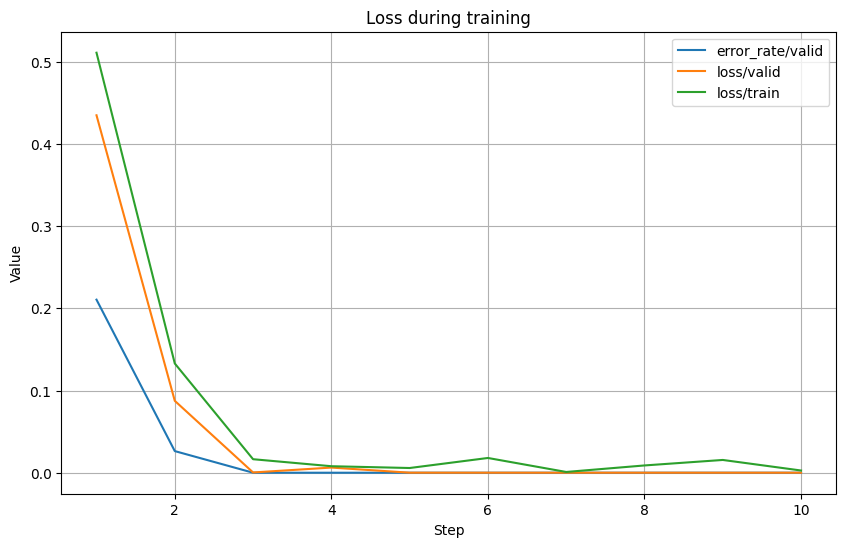

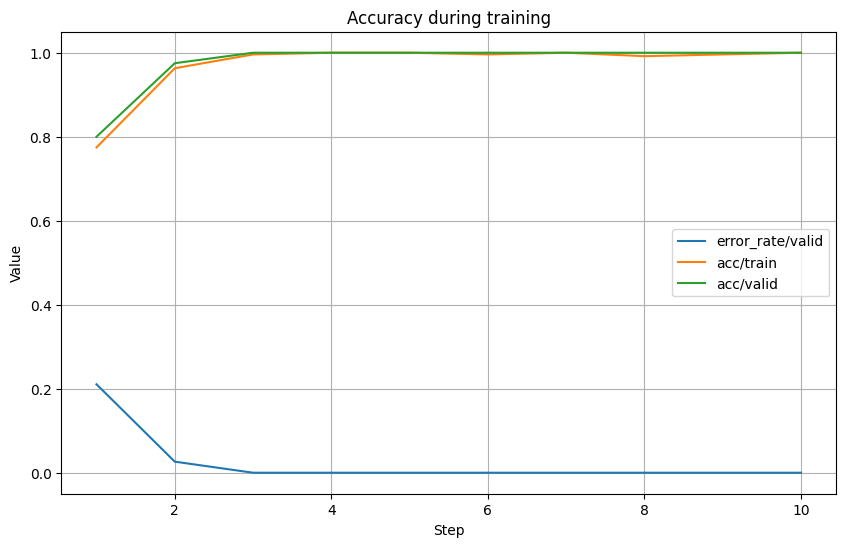

In [8]:
event_file = "/home/ulaval.ca/maelr5/scratch/parkinsons-results/hubert/base/phrases/1986/tb_logs/events.out.tfevents.1745547537.ul-val-pr-cpc02.l.ul.ca.2954688.0"
plot_training(event_file)

